# TABLE OF CONTENTS

####  INITIAL DATA PREPARATION
* [Initial Data Imports, Variable Explanations & Merging](#initial_data_import)
* [Initial Data Exploration & Visualisations](#ide)
* [Data: Dummy Variable Creation](#data_pre)
* [Feature Engineering & Data Cleaning](#feature_eng)

#### Classification Models
* [Un-tuned classification models comparisons & cross validation testing](#models)
* [Tuned classification models comparisons](#tuned_models)
    * [Additional Voting Classifier Approaches](#add_vc)
* [Tuned Classification Models on Test Data (out-of-sample) Prediction Accuracy](#oos_models)
* [Final Model Prediction Results Summary and Discussion](#model_results)

## BRIEF PROJECT OUTLINE: 

### PURPOSE OF CLASSIFICATION MODELS & PROJECT 
* The overarching purpose of these models (this project) is to determine why some loyalty customers have chosen to opt into email marketing and others have chosen to opt out. The data shows that those customers who opt in have higher average spends, thus it is important to determine whether customers who are already spending more choose to opt in or whether opting in results in a higher average spend. To determine this, I construct various data features which capture demographics of customers and utilise various classification models to determine outcomes based off the input demographics / data features. A desired takeaways is to understand what features underpin each group and inform decisions on how to influence customers to opt into email marketing. 

#### THE  DATA: 
* Original data is 52K entries of sales data across 12+ departments and several hundred unique customers with unique individual characteristics: post code, age, gender, shopping frequency and average spend across different departments. Data ranges from 2019 to early 2021.

#### PROJECT FLOW:

* After initial data exploration and data cleaning, I create a variety of features for the classification models:
    * Customer Duration (Time between first and last transactions)
    * One-Hot Encode post code data by customer, customer gender, department sales frequencies by customer
    * Standardise these variables without mean (Ex. post-code) to preserve the sparse matrix nature of the data
        * Also standardise: age of each customer
        
        
* A severe class imbalance problem was present between customers who opted into email marketing (majority class) vs those who didn't (minority class). To remedy this, I upscaled the minority class with replacement to balance the two classes
    * Also tried downscaling the majority class in a separate iteration and found the former method to be superior


* I first run the following models before tuning and compare performance (accuracy) across the average of (5) cross validations on the training data
    * Naive Bayes (baseline measurement)
    * Logistic Regression
    * Decision Tree Classifier
    * Random Forest Classifier
    * K-nearest neighbors
    * Support Vector Classifier
    * XGBoost Classifier
    * Soft & Hard Voting Classifiers


### UN-TUNED (INITIAL) MODEL RESULTS
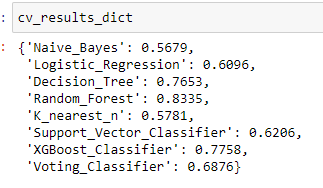


* With the exception of the naive bayes, I tune the above models and re-measure the performance the same way
    * I also experiment with different weightings of soft voting classifiers 
    
    
###  TUNED CLASSIFICATION MODEL RESULTS     
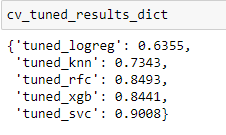

    
### OUT OF SAMPLE PREDICTION RESULTS    
* The final result is the individual tuned classification models perform best; consequently, I perform predictions on the test data with the trained model to measure out-of-sample predictive strength

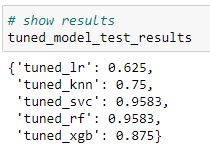



###### FOR FULL RESULTS REPORTING AND VISUALS, FOLLOW THE ABOVE HYPERLINKS FOR THE RELATIVE SECTION

## PACKAGES
* NOTE: some additional packages are imported in the "classification" models section, concurrently with the introduction of each model 

In [1]:
## import packages ## 
import warnings
import sys
if not sys.warnoptions:
    warnings.filterwarnings("ignore")  

In [2]:
# core packages
import numpy as np 
import pandas as pd

## graphing packages ## 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## date working / printing packages
import datetime
from datetime import date, timedelta, datetime  

In [3]:
# model packages 
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
## optional packages / display preferences ##
from IPython.display import display
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn')

<a id='initial_data_import'></a>

## IMPORT FIRST DATA FILE: SALES DATA
* E.G. data contains sales by department, by customer

In [3]:
# import xlsx file
weekly_customer_sales_bydep = pd.read_excel(r'weekly_customer_sales_department_data_mw.xlsx')

In [5]:
# [optional] temporarily need REGEX; then can del re
import regex as re

# CLEAN DF COLUMN NAMES OF SYMBOLS / SPACES: 
# make all characters lowercase, remove spaces etc.
for i, val in enumerate(weekly_customer_sales_bydep.columns.values):
    weekly_customer_sales_bydep.columns.values[i] = re.sub('[^A-Za-z0-9]+', '', val.lower())

In [9]:
# === NOTE === # 
# to protect the anonymity of the data, the actual store_name has been replaced with a code word
# this store name has been hidden below, replaced by the string "####"
weekly_customer_sales_bydep['store'] = weekly_customer_sales_bydep['store'].replace("####", "MW")

In [16]:
# for privacy concerns, we keep identify a unique customer by their card number and hide their full-name
weekly_customer_sales_bydep.drop(['fullname'], axis=1, inplace=True)

In [18]:
weekly_customer_sales_bydep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51524 entries, 0 to 51523
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   store            51524 non-null  object 
 1   weekendingname   51524 non-null  object 
 2   sales            51524 non-null  float64
 3   baskets          51524 non-null  int64  
 4   sumofcardnumber  48741 non-null  float64
 5   sumofage         14926 non-null  float64
 6   gender           48741 non-null  object 
 7   city             16414 non-null  object 
 8   department       51524 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 3.5+ MB


* NOTE: a lot of missing data around age and city (post-code)

In [21]:
# rename some of those long/verbose column names for simplicity 
weekly_customer_sales_bydep.rename(columns = {'weekendingname':'week_ending',
                                             'sumofcardnumber':'card_num',
                                             'sumofage':'age'}, inplace=True)

In [22]:
# visualise Null values for the DF
weekly_customer_sales_bydep.isnull().sum()

store              0
week_ending        0
sales              0
baskets            0
card_num        2783
age            36598
gender          2783
city           35110
department         0
dtype: int64

#### Remove sales entries that don't have a corressponding customer (card_num) attached
* Other category NaN - E.G. Gender, will be handled in the feature creation section just before the classification models

In [30]:
# we see at the begenning of each "week_ending", there is aggregate department-level store sales information we don't need
# there is no associated card_num with this information obviously, so we can drop it
weekly_customer_sales_bydep.dropna(subset=['card_num'], inplace=True)

In [31]:
weekly_customer_sales_bydep.head()

,store,week_ending,sales,baskets,card_num,age,gender,city,department
23,MW,"Jan 06, 2019",8.58,3,1.112257e+17,NaN,Unknown,NaN,BREAD
24,MW,"Jan 06, 2019",34.75,1,1.112257e+17,NaN,Unknown,NaN,CIGS & TOBACCO
25,MW,"Jan 06, 2019",4.99,1,1.112257e+17,NaN,Unknown,NaN,CONFECTIONERY
26,MW,"Jan 06, 2019",11.44,1,1.112257e+17,NaN,Unknown,NaN,DAIRY
27,MW,"Jan 06, 2019",26.62,4,1.112257e+17,NaN,Unknown,NaN,FRUIT & VEG


### [OPTIONAL] 
* Pickle the DF thus far

In [32]:
weekly_customer_sales_bydep.to_pickle("./weekly_customer_sales_bydep.pkl")
#weekly_customer_sales_bydep = pd.read_pickle("./weekly_customer_sales_bydep.pkl") 

## IMPORT (2ND DATA FILE): CUSTOMER INFORMATION FILE
* Contains relevant information like: email marketing allowed, post code etc. 
* This data will be merged onto the above file "weekly_customer_sales_bydep"

In [37]:
# import supplementary file with customer information
customer_emailopt_in_file = pd.read_excel(r'mw_customer_information_emailoptin.xlsx')

In [40]:
# once again, drop the full_name for privacy reasons 
customer_emailopt_in_file.drop(['Full Name'], axis=1, inplace=True)

In [42]:
# to facilitate the merge, we will rename the relevant columns 
customer_emailopt_in_file.rename(columns={'IsHomeEmailMarketingAllowed':'email_status',
                                         'Sum of Card Number':'card_num',
                                         'PostCode':'post_code'}, inplace=True)

## E.G. Of the two DFs data for one individual customer (card_num)
* Visualise the data available in each DF for a singular random customer with card_num = '59626613925472'

In [44]:
customer_emailopt_in_file.loc[customer_emailopt_in_file.card_num==59626613925472]

,Store,Gender,City,email_status,card_num,Sum of CardCustomerAccountKey,post_code
0,Mermaid Waters,Female,Miami,True,59626613925472,4070132,4220.0


In [46]:
weekly_customer_sales_bydep.loc[weekly_customer_sales_bydep.card_num==59626613925472].head()

,store,week_ending,sales,baskets,card_num,age,gender,city,department
6017,MW,"Apr 21, 2019",1.99,1,5.962661e+13,792.0,Female,Miami,BREAD
6018,MW,"Apr 21, 2019",5.00,1,5.962661e+13,792.0,Female,Miami,CONFECTIONERY
6019,MW,"Apr 21, 2019",1.00,1,5.962661e+13,792.0,Female,Miami,DAIRY
6020,MW,"Apr 21, 2019",15.00,1,5.962661e+13,792.0,Female,Miami,SEASONAL LINES
6021,MW,"Apr 21, 2019",3.00,1,5.962661e+13,792.0,Female,Miami,SNACKFOODS


In [49]:
# filter for the information we need in the merge (don't need gender / city again etc.)
customer_emailopt_in_file = customer_emailopt_in_file[['card_num','email_status','post_code']]

## MERGE THE TWO DFs 
* merge sales data with customer identifying information

In [57]:
weekly_customer_fulldf = pd.merge_ordered(weekly_customer_sales_bydep, customer_emailopt_in_file, 
                                          fill_method='ffill', right_by='card_num')

In [58]:
weekly_customer_fulldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26903 entries, 0 to 26902
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         26693 non-null  object 
 1   week_ending   26693 non-null  object 
 2   sales         26693 non-null  float64
 3   baskets       26693 non-null  float64
 4   card_num      26903 non-null  int64  
 5   age           13869 non-null  float64
 6   gender        26693 non-null  object 
 7   city          15734 non-null  object 
 8   department    26693 non-null  object 
 9   email_status  26903 non-null  bool   
 10  post_code     24577 non-null  float64
dtypes: bool(1), float64(4), int64(1), object(5)
memory usage: 2.1+ MB


In [68]:
#.E.G. of the merged DF 
weekly_customer_fulldf

,store,week_ending,sales,baskets,card_num,age,gender,city,department,email_status,post_code
0,MW,"Apr 21, 2019",1.99,1.0,59626613925472,792.0,Female,Miami,BREAD,True,4220.0
1,MW,"Apr 21, 2019",5.00,1.0,59626613925472,792.0,Female,Miami,CONFECTIONERY,True,4220.0
2,MW,"Apr 21, 2019",1.00,1.0,59626613925472,792.0,Female,Miami,DAIRY,True,4220.0
3,MW,"Apr 21, 2019",15.00,1.0,59626613925472,792.0,Female,Miami,SEASONAL LINES,True,4220.0
4,MW,"Apr 21, 2019",3.00,1.0,59626613925472,792.0,Female,Miami,SNACKFOODS,True,4220.0
...,...,...,...,...,...,...,...,...,...,...,...
26898,MW,"Jan 24, 2021",3.32,1.0,5420602479386,NaN,Unknown,NaN,SNACKFOODS,True,4218.0
26899,MW,"Sep 15, 2019",3.00,1.0,2710202165626,NaN,Unknown,NaN,FRUIT & VEG,False,NaN
26900,MW,"Sep 15, 2019",4.59,1.0,2710202165626,NaN,Unknown,NaN,INSTORE BAKERY,False,NaN
26901,MW,"Sep 15, 2019",4.50,1.0,2710202165626,NaN,Unknown,NaN,SNACKFOODS,False,NaN


In [4]:
## [OPTIONAL] pickle the DF:
#weekly_customer_fulldf.to_pickle("./weekly_customer_fulldf.pkl")
#weekly_customer_fulldf = pd.read_pickle("./weekly_customer_fulldf.pkl") 

<a id='ide'></a>

## INITIAL DATA EXPLORATION

In [5]:
weekly_customer_fulldf = pd.read_pickle("./weekly_customer_fulldf.pkl") 

In [6]:
#E.G. of data input for the visuals and tables
weekly_customer_fulldf.head()

,store,week_ending,sales,baskets,card_num,age,gender,city,department,email_status,post_code
0,MW,"Apr 21, 2019",1.99,1.00,59626613925472,792.00,Female,Miami,BREAD,True,"4,220.00"
1,MW,"Apr 21, 2019",5.00,1.00,59626613925472,792.00,Female,Miami,CONFECTIONERY,True,"4,220.00"
2,MW,"Apr 21, 2019",1.00,1.00,59626613925472,792.00,Female,Miami,DAIRY,True,"4,220.00"
3,MW,"Apr 21, 2019",15.00,1.00,59626613925472,792.00,Female,Miami,SEASONAL LINES,True,"4,220.00"
4,MW,"Apr 21, 2019",3.00,1.00,59626613925472,792.00,Female,Miami,SNACKFOODS,True,"4,220.00"


### BRIEF INTRODUCTION TO DEPARTMENT SALES DYNAMICS 
* Unsurprisingly, Tobacco has the highest average transaction value; although, this will likely not translate into significance in our classification model as tobacco does not count towards accumulating loyalty points. 
    * The same logic holds true for EPAY/PHONECARDS and LOTTO/SCRATCHIT
    
* Thus, the highest average value transaction for an actual department category is meat, followed by prized-poultry (cooked, ready-to-eat, BBQ meat out of the deli-case); these items generally have a fixed cost of 10 dollars so the average is also unsurprisingly around that amount. 

* We also observe fairly similar average spend amounts around other categories, like: fruit & veg, grocery, deli, dairy etc. We expect at least some of these items to be significant in the classification models 

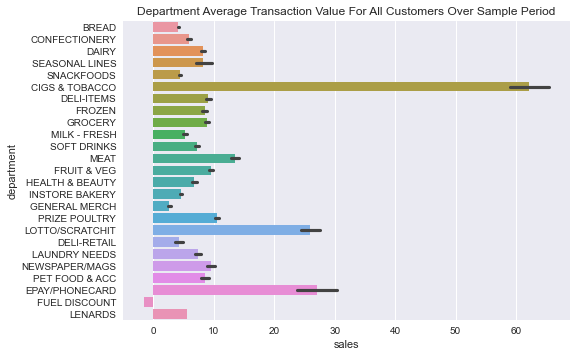

In [18]:
sns.barplot(data=weekly_customer_fulldf, y='department', x='sales')
plt.title('Department Average Transaction Value For All Customers Over Sample Period');
# note: fuel_discount (will be dropped eventually) is negative because it is an actual discount on check-out value

### DEPARTMENT TOTAL TRANSACTION SIZES
* In terms of total number of transactions involving these departments, there seems to be a reasonable representation for all departments with the exception of: deli-retail and seasonal lines
    * seasonal lines is somewhat expected given these items are only available at limited times of the year, however, they may play an important role in the cusotmer email-opt in preferences if people deem these limited-availability items of high demand, thus I will leave it in the model. 
    * deli-retail is an odd one, it actually represents a few specific deli lines, measured on how the items are sold (E.G. most are sold by weight, hence deli-items, but some are by fixed bundle sizes or units- these are deli-retail). More or less, the type of item is identical to what is found by deli-items, thus the two categories could be combined or deli-retail simply dropped due to it being almost a negligible quantity. 

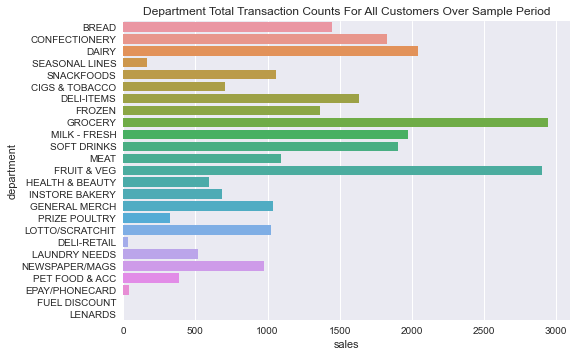

In [22]:
sns.barplot(data=weekly_customer_fulldf, y='department', x='sales', estimator=len)
plt.title('Department Total Transaction Counts For All Customers Over Sample Period');


## CUSTOMER AGE
* This variable is partially "corrupted" - the values represent a scale; that is, smaller values = younger and larger values = older, thus it is not entirely useless. Although, I do not have access to the scale parameter to convert these values into real values that represent biological ages
* At any rate, it can be observed that the bulk of the transactions (customers) are being made by people on the younger side of the scale
    * This is potentially representative of the fact that younger people are more likely to adopt "modern" technology and be invested in customer loyalty / email marketing programs vs. their older counterparts etc.
    
    
#### Important to note: age data is only available for 1/3 of the data set, meaning it cannot reliably make conclusions about the entire data set and we cannot apply CLT without first making an assumption about the distribution of the data

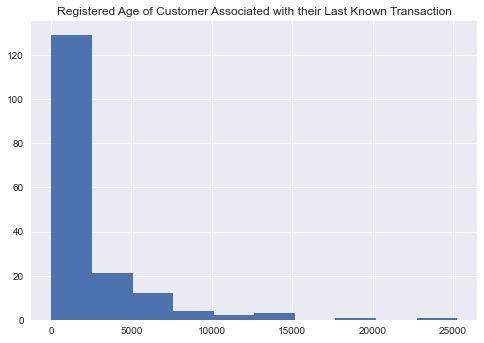

In [30]:
# definitely a skew towards the lower end of the age tier 
# this will be resolved if the variable is used in the final model by standardisation
plt.hist(weekly_customer_fulldf.groupby(['card_num'])['age'].last())
plt.title('Registered Age of Customer Associated with their Last Known Transaction');

### BREAKDOWN OF AVERAGE SALES BY AGE SCALE

* NOTE: Age is scaled and does not represent true values for privacy reasons when releasing the data 

In [16]:
# show average sales by age bin (1/5) increments and by email_status
pd.pivot_table(weekly_customer_fulldf, index='email_status', columns = pd.cut(weekly_customer_fulldf['age'], bins=5),
              values=['sales'], aggfunc='mean')

sales                                       \
age          (-5.238, 5067.6] (5067.6, 10115.2] (10115.2, 15162.8]   
email_status                                                         
False                    7.22             11.23               7.20   
True                     7.85             11.08              17.97   

                                                    
age          (15162.8, 20210.4] (20210.4, 25258.0]  
email_status                                        
False                      6.79                NaN  
True                        NaN              11.19

In [19]:
# number of transactions in each age bin
pd.pivot_table(weekly_customer_fulldf, index='email_status', columns = pd.cut(weekly_customer_fulldf['age'], bins=5),
              values=['sales'], aggfunc='count')

sales                                       \
age          (-5.238, 5067.6] (5067.6, 10115.2] (10115.2, 15162.8]   
email_status                                                         
False                    2271              1352                309   
True                     5598              2795               1039   

                                                    
age          (15162.8, 20210.4] (20210.4, 25258.0]  
email_status                                        
False                       248                  0  
True                          0                257

* Judging from the middle age cut (3/5) which by counts is actually refering to the roughly the oldest 10% of the customer base, the average spend is indeed significantly higher among email opt-ins vs. email opt-outs (17.97 Vs. 7.20) and across the last two bins (11.19 vs 6.79)
    * This would suggest the older customer who chooses to opt into emails is also correlated with a higher spend; the direction of the causality (emails = more sales, or more sales already = opt into emails) cannot yet be infered.

## CUSTOMER GENDER
* Gender is known for roughly 80% of the transactions in the data-set
* Later, in feature engineering, a separate technique to handle the unknown genders will be introduced

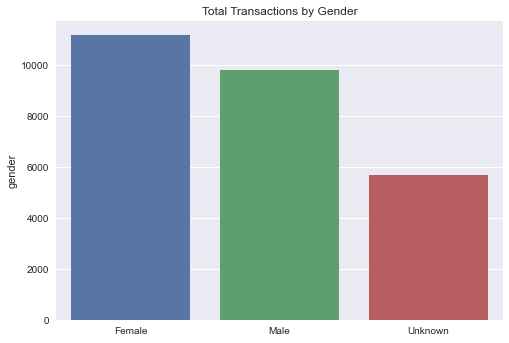

In [31]:
sns.barplot(weekly_customer_fulldf['gender'].value_counts().index,
           weekly_customer_fulldf['gender'].value_counts()).set_title("Total Transactions by Gender")
plt.show();

## CUSTOMER DYNAMICS BY EMAIL STATUS
* The majority of transactions are made by people who have opted into emails; but there remains a significant portion of transactions by people with loyalty cards who have chosen not to. Thus, the interesting problem emerges of what underlying phenomena is there to explain this divide? 

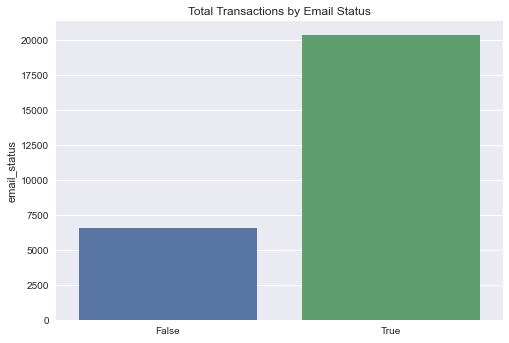

In [27]:
sns.barplot(weekly_customer_fulldf['email_status'].value_counts().index,
           weekly_customer_fulldf['email_status'].value_counts()).set_title("Total Transactions by Email Status")
plt.show()

* The importance of converting people is demonstrated by the average sales value of customers who opt into email marketing being higher than those who don't; thus, it should be determined which factors can help convert these customers

In [50]:
pd.pivot_table(weekly_customer_fulldf, index='email_status',
              values=['sales'], aggfunc='mean')

,sales
email_status,
False,8.70
True,10.04


#### Further breaking down the average spend by email status with gender
* We see a great deal of the gains in average spend stem from converting males to opting into email

In [51]:
print("Sales & Baskets Daily Transaction Counts By Gender & Email Status", '\n', "--"*25)

pd.pivot_table(weekly_customer_fulldf, index='email_status', columns='gender',
              values=['sales'], aggfunc='mean')


Sales & Baskets Daily Transaction Counts By Gender & Email Status 
 --------------------------------------------------


sales              
gender       Female  Male Unknown
email_status                     
False          9.60  6.62    9.10
True           9.53 10.42   10.37

## Department Sales Dynamics By Email Status
* The results are somewhat conflicting; the 3 main stay departments (tobacco, lotto, phonecards) have significantly higher average spends than their non-email counterparts; this might suggest that these items are staple/repeat purchases to customers who have already delegated the store as their chosen frequent store.
* There are some modest gains in impulse categories (snackfoods, softdrinks) etc.
    * although, these are generally balanced out by modest loses in other departments; resulting in a fairly neutral net outcome
    
    
### NOTE: median was also performed and found virtually identical results; suggesting that the department sales distributions are not heavily skewed 

* Additionally, is it imperative to note that this data represents loyalty members (opt-in) vs loyalty members (email opt-out); a comparison between loyalty members in general vs. non-loyalty members average department spends would likely be more in line with expectations that loyalty members spend more than non-members. 

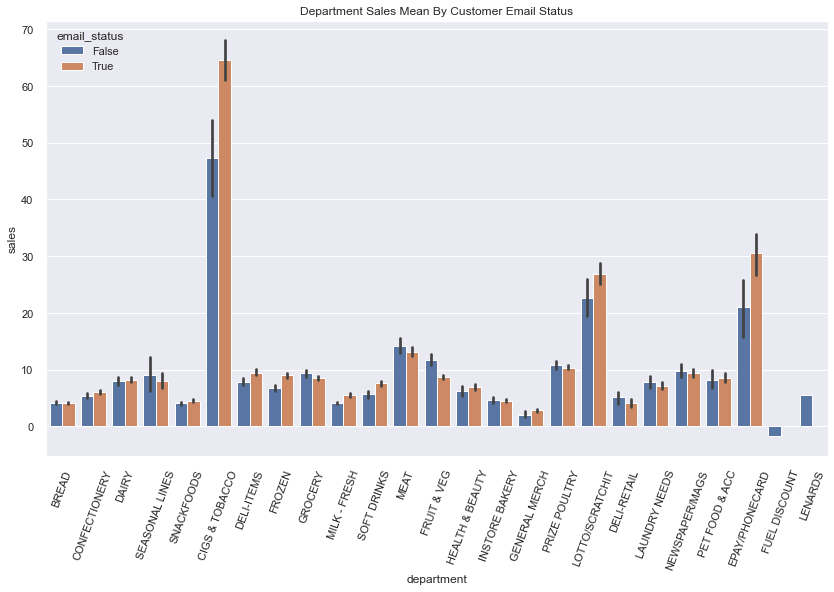

In [76]:
sns.set(rc={'figure.figsize':(14,8)})
sns.barplot(x='department', y='sales', hue='email_status', data=weekly_customer_fulldf, estimator=np.mean)
plt.xticks(rotation=70)
plt.title('Department Sales Mean By Customer Email Status');

## VISUALISE THE DISTRIBUTION OF INDIVIDUAL CUSTOMER'S (FIRST) TRANSACTION OVER TIME BY EMAIL STATUS

* The distribution of customer first recorded loyalty transaction over the sample horizon, the data shows there are still a great deal of new customers entering the system, most of whom have opted into emails but some of whom still have chosen not to
    * One interesting observation is the tendency for new transactions (akin to new sign-ups) clustering around December, particularly so in 2020 and 2021, meaning the holiday (summer) season is more attractive to signing up new customers
    * Furthermore, quite a few customers have rather large first spend amounts, although the majority of customer's first transaction value is roughly 0-10 dollars; likely indicating they used it as a top-up or convenience shop

In [80]:
# convert the DF time variable to datetime for the index of the graph
weekly_customer_fulldf['week_ending'] = pd.to_datetime(weekly_customer_fulldf['week_ending'])

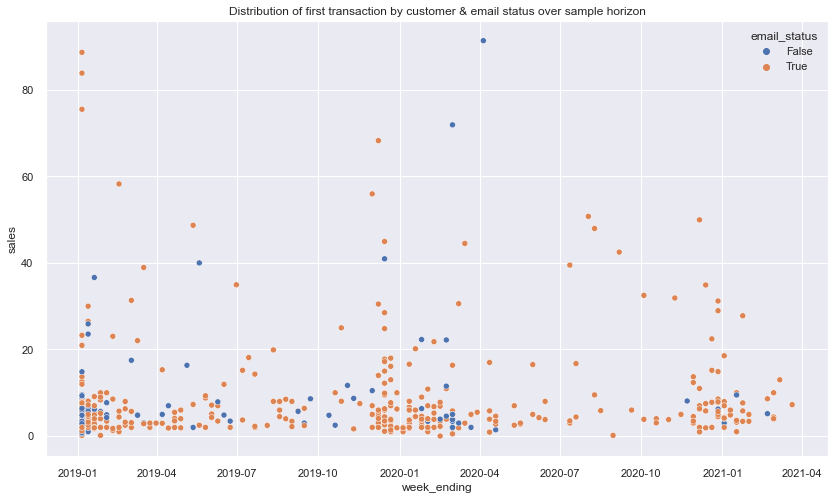

In [84]:
sns.set(rc={'figure.figsize':(14,8)})
sns.scatterplot( data=weekly_customer_fulldf.groupby('card_num').first(),
                y='sales', x='week_ending', hue='email_status')
plt.title('Distribution of first transaction by customer & email status over sample horizon');

### VISUALISE THE DISTRIBUTION OF INDIVIDUAL CUSTOMER'S (LAST) TRANSACTION OVER TIME BY EMAIL STATUS
* Interesting, a lot of customers with email_status set to false made their last transactions around the same christmas time; this perhaps suggests they signed up for the holiday season and perhaps some factors contributed towards their decision not to return, or that their shopping needs/habits changed drastically after the holidays. 

* Interestingly, most customer's last transaction amount is less clustered around zero than their first transaction but there are far less extreme positive outliers here than in the first transaction group. (E.G. max transaction value here is ~ 65 dollars Vs. quite a few spends over 80 dollars for first transactions)

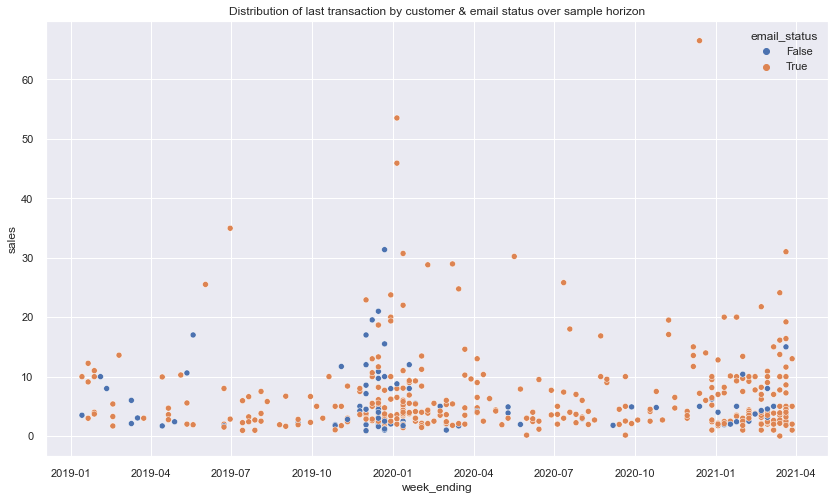

In [83]:
#sns.set(rc={'figure.figsize':(14,8)})
sns.scatterplot( data=weekly_customer_fulldf.groupby('card_num').last(),
                y='sales', x='week_ending', hue='email_status')
plt.title('Distribution of last transaction by customer & email status over sample horizon');

<a id='data_pre'></a>

## DATA PREPROCESSING
* Dummy Variable Creation For Departments

In [28]:
## DF with department category aggregated (No Hot Encoding / Dummies)
## OPTIONAL: load pickle from previous step
weekly_customer_fulldf = pd.read_pickle("./weekly_customer_fulldf.pkl") 

In [29]:
# create department-labeled dummy variables for each department
dep_dummies = pd.get_dummies(weekly_customer_fulldf.department)

In [31]:
# there are a few specialised categories with their own labels 
# E.G. tobacco, health and beauty goods, lotto, magazines: simply re-name them for convenience
dep_dummies.rename(columns={'CIGS & TOBACCO':'TOBACCO',
                                         'HEALTH & BEAUTY':'H_AND_B',
                                         'LOTTO/SCRATCHIT':'LOTTO',
                           'NEWSPAPER/MAGS':'MAGAZINES'}, inplace=True)

In [33]:
# merge onto the main DF with the data
weekly_customer_dep_dummies = pd.concat([weekly_customer_fulldf, 
                                        dep_dummies], axis=1)

In [34]:
# E.G. of the resulting DF 
weekly_customer_dep_dummies.head()

,store,week_ending,sales,baskets,card_num,age,gender,city,department,email_status,post_code,BREAD,TOBACCO,CONFECTIONERY,DAIRY,DELI-ITEMS,DELI-RETAIL,EPAY/PHONECARD,FROZEN,FRUIT & VEG,FUEL DISCOUNT,GENERAL MERCH,GROCERY,H_AND_B,INSTORE BAKERY,LAUNDRY NEEDS,LENARDS,LOTTO,MEAT,MILK - FRESH,MAGAZINES,PET FOOD & ACC,PRIZE POULTRY,SEASONAL LINES,SNACKFOODS,SOFT DRINKS
0,MW,"Apr 21, 2019",1.99,1.00,59626613925472,792.00,Female,Miami,BREAD,True,"4,220.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,MW,"Apr 21, 2019",5.00,1.00,59626613925472,792.00,Female,Miami,CONFECTIONERY,True,"4,220.00",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,MW,"Apr 21, 2019",1.00,1.00,59626613925472,792.00,Female,Miami,DAIRY,True,"4,220.00",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,MW,"Apr 21, 2019",15.00,1.00,59626613925472,792.00,Female,Miami,SEASONAL LINES,True,"4,220.00",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,MW,"Apr 21, 2019",3.00,1.00,59626613925472,792.00,Female,Miami,SNACKFOODS,True,"4,220.00",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [36]:
# [OPTIONAL] pickle the DF:
#weekly_customer_dep_dummies.to_pickle("./weekly_customer_dep_dummies.pkl")
weekly_customer_dep_dummies = pd.read_pickle("./weekly_customer_dep_dummies.pkl") 

<a id='feature_eng'></a>

## FINAL FEATURE ENGINEERING & DATA MANIPULATION / CLEANING 
* E.G. 
    * Create a customer_duration feature (how long have they been a loyalty member)
    * Aggregate transaction counts by department and scale the result
    * Create a dummy variable for each gender + 3rd category for missing gender data
    * drop unneeded variables after some iterative testing 
    
#### POTENTIAL EXPANSION AT A LATER DATE: 
* Use NLP to infer gender from names to fill the gab of missing gender data

In [20]:
## read in pickle if resuming 
weekly_customer_dep_dummies = pd.read_pickle("./weekly_customer_dep_dummies.pkl") 

In [21]:
## NOT USED IN THE FINAL MODEL AFTER ITERATION


# convert sales to log to assist with the highly skewed - un-even distribution 
weekly_customer_dep_dummies['log_sales'] = np.log(weekly_customer_dep_dummies.sales+1)

### CREATE TOTAL SALES BY CUSTOMER FEATURE 

In [22]:
# for testing purposes, make a copy of DF thus far 
weekly_customer_dep_dummies_cleaned = weekly_customer_dep_dummies.copy()

In [23]:
# drop NaN from Log-Sales, which also dropping NaN from sales
weekly_customer_dep_dummies_cleaned.dropna(subset=['log_sales'], inplace=True)

### DROP MISSING AGE VALUES (EXPERIMENTAL)
* Initially excluded from the first iteration, but re-added in subsequent tests

In [26]:
# drop missing age values (roughly 25% of customer data)
weekly_customer_dep_dummies_cleaned.dropna(subset=['age'], inplace=True)

### VARIABLES TO BE DROPPED AS THEY'RE OBSOLETE / INEFFECTIVE 
* City = replaced by post_code 
* Store = all customers in this data file pertain to the same store
* Department = replaced by individual department dummy variables
* Baskets 
    * No longer has any meaning in the context of aggregated department frequencies

    
### DROP NAN ROWS FROM SOME VARIABLES: 
* Sales / Post Code 



In [27]:
# drop those variables
weekly_customer_dep_dummies_cleaned = weekly_customer_dep_dummies_cleaned.drop(['city','store', 
                                                                                'department', 'baskets'], axis=1)

In [28]:
# drop the subset of customers with missing postcodes: (not many)
print("pre (post_code) drop DF len: {}".format(len(weekly_customer_dep_dummies_cleaned)))
weekly_customer_dep_dummies_cleaned.dropna(subset=['post_code'], inplace=True)
print("post (post_code) drop DF len: {}".format(len(weekly_customer_dep_dummies_cleaned)))

pre (post_code) drop DF len: 13868
post (post_code) drop DF len: 13741


### Encode a dummy variable for gender (M/F) & A separate variable to indicate missing gender values
* A potentially more sophisticated method of guessing gender based of a NLP model could be implemented at a later date 

In [29]:
# convert to string 
weekly_customer_dep_dummies_cleaned['gender'] = weekly_customer_dep_dummies_cleaned.gender.astype(str)

In [30]:
# if gender is unknown - set dummy to (1) else (0)
weekly_customer_dep_dummies_cleaned['gender_unknown'] = weekly_customer_dep_dummies_cleaned['gender'].apply(
lambda x: 1 if x=='Unknown' else 0)

# in the male column: set == 1 if male; else 0 
weekly_customer_dep_dummies_cleaned['male'] = weekly_customer_dep_dummies_cleaned['gender'].apply(
lambda x: 1 if x=='Male' else 0)

# repeat for females 
weekly_customer_dep_dummies_cleaned['female'] = weekly_customer_dep_dummies_cleaned['gender'].apply(
lambda x: 1 if x=='Female' else 0)

In [31]:
# drop the original gender column as it is now not needed
weekly_customer_dep_dummies_cleaned = weekly_customer_dep_dummies_cleaned.drop(['gender'], axis=1)

In [32]:
#E.G: gender_unknown = (0) as gender is known -- then, gender = (1) for female, (0) for male
weekly_customer_dep_dummies_cleaned.head()

,week_ending,sales,card_num,age,email_status,post_code,BREAD,TOBACCO,CONFECTIONERY,DAIRY,DELI-ITEMS,DELI-RETAIL,EPAY/PHONECARD,FROZEN,FRUIT & VEG,FUEL DISCOUNT,GENERAL MERCH,GROCERY,H_AND_B,INSTORE BAKERY,LAUNDRY NEEDS,LENARDS,LOTTO,MEAT,MILK - FRESH,MAGAZINES,PET FOOD & ACC,PRIZE POULTRY,SEASONAL LINES,SNACKFOODS,SOFT DRINKS,log_sales,gender_unknown,male,female
0,"Apr 21, 2019",1.99,59626613925472,792.00,True,"4,220.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.10,0,0,1
1,"Apr 21, 2019",5.00,59626613925472,792.00,True,"4,220.00",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.79,0,0,1
2,"Apr 21, 2019",1.00,59626613925472,792.00,True,"4,220.00",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.69,0,0,1
3,"Apr 21, 2019",15.00,59626613925472,792.00,True,"4,220.00",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2.77,0,0,1
4,"Apr 21, 2019",3.00,59626613925472,792.00,True,"4,220.00",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.39,0,0,1


## ADDITIONAL FEATURES CREATION 
* Average Spend by Customer Transactions
* Customer duration (last-first transaction dates)


#### HANDLING THE CLASS IMBALANCE: 
* This will be addressed slightly below by upscaling the minority class (resampling with replacement to match the majority class)
    * It was possible in some models E.G. SVC to handle this directly, but other models did not support it so it was manually implemented beforehand for consistency

### extract the email status and post-code of the last data entry by customer (presuming post-code doesn't change through-out the sample)
* Essentially, extract variables that are not expected to change (excluding email status, which might change but will be handled later)

In [46]:
customer_email_postcode_df = weekly_customer_dep_dummies_cleaned.groupby(['card_num'])[
    'email_status','post_code','gender_unknown','male','female','age'].last()

In [47]:
customer_email_postcode_df.head()

,email_status,post_code,gender_unknown,male,female,age
card_num,,,,,,
2710201787225,False,"4,227.00",0,1,0,25.00
2710202677549,False,"4,067.00",0,0,1,29.00
2710202683021,True,"4,069.00",0,0,1,30.00
2710203126152,True,"4,169.00",0,0,1,40.00
2710300512261,False,"4,218.00",0,1,0,20.00


### CREATE SUMMARY OF DEPARTMENT FREQUENCIES BY CUSTOMER 
* By customer, sum each departments sales values

In [48]:
cust_dep_sums = weekly_customer_dep_dummies_cleaned.groupby(['card_num'])['BREAD', 'TOBACCO', 'CONFECTIONERY',
       'DAIRY', 'DELI-ITEMS', 'DELI-RETAIL', 'EPAY/PHONECARD', 'FROZEN',
       'FRUIT & VEG', 'FUEL DISCOUNT', 'GENERAL MERCH', 'GROCERY', 'H_AND_B',
       'INSTORE BAKERY', 'LAUNDRY NEEDS', 'LENARDS', 'LOTTO', 'MEAT',
       'MILK - FRESH', 'MAGAZINES', 'PET FOOD & ACC', 'PRIZE POULTRY',
       'SEASONAL LINES', 'SNACKFOODS', 'SOFT DRINKS'].sum()

# unique customer rows in the data 
print(len(cust_dep_sums))

170


## CREATE CUSTOMER SALES FEATURES
* Include: Total Spend & Average Spend


In [49]:
cust_avgspend = weekly_customer_dep_dummies_cleaned.groupby([
    'card_num'])['sales'].mean()

## Create time-spent as customer feature 
* measured by the time between their first and last shops 

In [50]:
# if not already done, convert the week_ending to datetime format
weekly_customer_dep_dummies_cleaned['week_ending'] = pd.to_datetime(weekly_customer_dep_dummies_cleaned['week_ending'])

In [51]:
# create the duration variable as last transction - first transaction date by customer
cust_duration = weekly_customer_dep_dummies_cleaned.groupby(['card_num'])['week_ending'].max() - weekly_customer_dep_dummies_cleaned.groupby(['card_num'])['week_ending'].min()

In [52]:
# convert to DF and transpose to match dimensions of existing data
customer_durations_df = pd.DataFrame([cust_duration]).T

### Need to convert the data series to float (drop the .days part of the variable for the classification models)

In [53]:
# convert the days timedelta variable into hours 
customer_durations_df['week_ending'] = customer_durations_df['week_ending'] / np.timedelta64(1, 'h')

In [54]:
# divide the now floated (hours) variable by 24 to get back to days
customer_durations_df['week_ending'] = customer_durations_df['week_ending'] / 24

In [55]:
# rename variable for clarity 
customer_durations_df.rename(columns={'week_ending':'cust_duration'}, inplace=True)

In [56]:
# E.G. card_num and customer duration in (days)
customer_durations_df

,cust_duration
card_num,
2710201787225,0.00
2710202677549,0.00
2710202683021,0.00
2710203126152,0.00
2710300512261,0.00
...,...
512246819655144,336.00
542060132417800,343.00
761594497527545,329.00


* customer duration == 0 would represent customers who made a single purchase on the day they signed up

## Aggregate (concatenate) each of the individual data feature DF(S) into one final DF for the classification models

In [57]:
# concatenate each of the individual aggregated (card_num) data features DFs into one
customer_data_aggregated_df = pd.concat([customer_email_postcode_df, customer_durations_df,
                                        cust_avgspend, cust_dep_sums], axis=1)

In [28]:
## pickle the unscaled DF [NOT USED AFTER ITERATION]

#customer_data_aggregated_df.to_pickle("./customer_data_aggregated_df.pkl")
#customer_data_aggregated_df = pd.read_pickle("./customer_data_aggregated_df.pkl") 

## SCALED DATA DF VERSION
* Same as the above DF, except the aggregated department transaction frequencies will be standardised with sklearn's standard scaler; 
    * The mean_false = will be passed to preserve the sparse matrix nature of the data 

In [60]:
# create a copy of the existing DF to apply the scaling factor to
customer_data_aggregated_df_scaled = customer_data_aggregated_df.copy()

In [61]:
# combine the departments which all belong to the aggregate department category "deli"
customer_data_aggregated_df_scaled['DELI'] = customer_data_aggregated_df_scaled['DELI-ITEMS'] + customer_data_aggregated_df_scaled[
    'DELI-RETAIL'] + customer_data_aggregated_df_scaled['PRIZE POULTRY'] + customer_data_aggregated_df_scaled['LENARDS']

In [62]:
# drop the original frames 
customer_data_aggregated_df_scaled = customer_data_aggregated_df_scaled.drop([
    'DELI-ITEMS','DELI-RETAIL','PRIZE POULTRY','LENARDS'], axis=1)

In [63]:
# pass in "with_mean"=false, to account for the sparse matrix 
scale = StandardScaler(with_mean=False)

# scale transform the aggregated department frequencies
customer_data_aggregated_df_scaled[['BREAD', 'TOBACCO', 'CONFECTIONERY',
       'DAIRY', 'EPAY/PHONECARD', 'FROZEN',
       'FRUIT & VEG', 'FUEL DISCOUNT', 'GENERAL MERCH', 'GROCERY', 'H_AND_B',
       'INSTORE BAKERY', 'LAUNDRY NEEDS', 'LOTTO', 'MEAT',
       'MILK - FRESH', 'MAGAZINES', 'PET FOOD & ACC',
       'SEASONAL LINES', 'SNACKFOODS', 'SOFT DRINKS', 'DELI']] = scale.fit_transform(
    
customer_data_aggregated_df_scaled[['BREAD', 'TOBACCO', 'CONFECTIONERY',
       'DAIRY', 'EPAY/PHONECARD', 'FROZEN',
       'FRUIT & VEG', 'FUEL DISCOUNT', 'GENERAL MERCH', 'GROCERY', 'H_AND_B',
       'INSTORE BAKERY', 'LAUNDRY NEEDS', 'LOTTO', 'MEAT',
       'MILK - FRESH', 'MAGAZINES', 'PET FOOD & ACC',
       'SEASONAL LINES', 'SNACKFOODS', 'SOFT DRINKS','DELI']])

In [64]:
# scale the customer duration and sales (experimented with: mean=False and mean=True)
scale = StandardScaler(with_mean=False)

customer_data_aggregated_df_scaled[['cust_duration','sales','age']] = scale.fit_transform(
customer_data_aggregated_df_scaled[['cust_duration','sales','age']])

In [ ]:
# could try standardising age with scaler & mean=True in subsequent iterations

In [65]:
#E.G. of the scaled department variables but with the sparse matrix format preserved by the transformation
customer_data_aggregated_df_scaled.head()

,email_status,post_code,gender_unknown,male,female,age,cust_duration,sales,BREAD,TOBACCO,CONFECTIONERY,DAIRY,EPAY/PHONECARD,FROZEN,FRUIT & VEG,FUEL DISCOUNT,GENERAL MERCH,GROCERY,H_AND_B,INSTORE BAKERY,LAUNDRY NEEDS,LOTTO,MEAT,MILK - FRESH,MAGAZINES,PET FOOD & ACC,SEASONAL LINES,SNACKFOODS,SOFT DRINKS,DELI
card_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2710201787225,False,"4,227.00",0,1,0,0.01,0.00,0.63,0.00,0.00,0.12,0.00,0.00,0.00,0.09,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2710202677549,False,"4,067.00",0,0,1,0.01,0.00,0.75,0.00,0.00,0.12,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00
2710202683021,True,"4,069.00",0,0,1,0.01,0.00,1.84,0.00,0.00,0.00,0.11,0.00,0.15,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00
2710203126152,True,"4,169.00",0,0,1,0.01,0.00,1.43,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.26,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2710300512261,False,"4,218.00",0,1,0,0.01,0.00,0.85,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.00


## HOT ENCODING / DUMMY VARIABLE FOR POST-CODE


In [49]:
# scale the customer duration and sales (experimented with: mean=False and mean=True)
#scale = StandardScaler(with_mean=False)

#customer_data_aggregated_df_scaled[['post_code']] = scale.fit_transform(
#customer_data_aggregated_df_scaled[['post_code']])

In [68]:
# create department-labeled dummy variables for each department
postcode_dummies = pd.get_dummies(customer_data_aggregated_df_scaled.post_code)

In [ ]:
# merge onto the main DF with the data
weekly_customer_dep_dummies = pd.concat([weekly_customer_fulldf, 
                                        dep_dummies], axis=1)

In [71]:
customer_data_aggregated_df_scaled_2 = pd.concat([customer_data_aggregated_df_scaled, postcode_dummies], axis=1)

In [73]:
# change name back to keep consistency; could refactor variable names later 
customer_data_aggregated_df_scaled = customer_data_aggregated_df_scaled_2.copy()

## CREATE THE (y) VARIABLE TO BE PREDICTED: (email_status) 
* Eventually, drop this variable from the main DF into its own DF so that the data can predict the outcome variable 

In [75]:
# define the series from the main DF
y_emailstatus = customer_data_aggregated_df_scaled['email_status']

#### Convert the boolean (True/False) to (1, 0)
* WHERE:
    * 1 = True 
    * 0 = False

In [76]:
# this can be achieved by * (1) for each element; 
y_emailstatus = y_emailstatus*1

In [77]:
print("unique customers in sample: {}".format(len(y_emailstatus)))

unique customers in sample: 170


In [80]:
# rename the sales variable to more accurately reflect what it is now
customer_data_aggregated_df_scaled = customer_data_aggregated_df_scaled.rename(columns={'sales':'avg_sales'})

In [81]:
#(AFTER ITERATION) dropped deli-retail & realised "fuel_discount" should have already been dropped (neg values; no intuition)
customer_data_aggregated_df_scaled.drop(['FUEL DISCOUNT'], axis=1, inplace=True)

In [82]:
# E.G. final DF: 
customer_data_aggregated_df_scaled.head()

,email_status,post_code,gender_unknown,male,female,age,cust_duration,avg_sales,BREAD,TOBACCO,CONFECTIONERY,DAIRY,EPAY/PHONECARD,FROZEN,FRUIT & VEG,GENERAL MERCH,GROCERY,H_AND_B,INSTORE BAKERY,LAUNDRY NEEDS,LOTTO,MEAT,MILK - FRESH,MAGAZINES,PET FOOD & ACC,SEASONAL LINES,SNACKFOODS,SOFT DRINKS,DELI,2486.0,2489.0,4067.0,4069.0,4169.0,4210.0,4211.0,4213.0,4214.0,4215.0,4218.0,4220.0,4226.0,4227.0,4361.0,4370.0,4380.0,4849.0
card_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2710201787225,False,"4,227.00",0,1,0,0.01,0.00,0.63,0.00,0.00,0.12,0.00,0.00,0.00,0.09,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2710202677549,False,"4,067.00",0,0,1,0.01,0.00,0.75,0.00,0.00,0.12,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2710202683021,True,"4,069.00",0,0,1,0.01,0.00,1.84,0.00,0.00,0.00,0.11,0.00,0.15,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2710203126152,True,"4,169.00",0,0,1,0.01,0.00,1.43,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.26,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2710300512261,False,"4,218.00",0,1,0,0.01,0.00,0.85,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.00,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### pickle the featured-created DF for the classification models:

In [83]:
# PICKLE OBJECTS

#customer_data_aggregated_df_scaled.to_pickle("./customer_data_aggregated_df_scaled.pkl")
customer_data_aggregated_df_scaled = pd.read_pickle("./customer_data_aggregated_df_scaled.pkl") 
#y_emailstatus.to_pickle("./y_emailstatus.pkl")
y_emailstatus = pd.read_pickle("./y_emailstatus.pkl")

## HANDLING THE EXTREME CLASS IMBALANCE PROBLEM: UP-SAMPLE MINORITY CLASS
* Tried both up-sampling minority and down-sampling majority class; found the up-sampling method to be superior

In [85]:
# import sklearns utils function for resampling with replacement
from sklearn.utils import resample

In [87]:
# define the y_series from the column in the DF
customer_data_aggregated_df_scaled['y_emailstatus'] = y_emailstatus

In [89]:
# 120 to the majority class (email=True) Vs. 50 (email=False)
y_emailstatus.value_counts()

1    120
0     50
Name: email_status, dtype: int64

In [88]:
# split the data into two separate DF based off majority and minority classes
customer_majority = customer_data_aggregated_df_scaled[
    customer_data_aggregated_df_scaled.y_emailstatus==1]

customer_minority = customer_data_aggregated_df_scaled[
    customer_data_aggregated_df_scaled.y_emailstatus==0]

In [92]:
# upsample the minority class with replacement to match the length of the majority class (120)
customer_data_minority_upsampled = resample(customer_minority,
                                                         replace=True,
                                                         n_samples=y_emailstatus.value_counts()[1],
                                                         random_state=123)

In [93]:
# re-join the now upsampled minority class with the original majority class 
# should now be balanced (120:120)
customer_majority_upsampled_df = pd.concat([customer_data_minority_upsampled, customer_majority])

In [95]:
# pickle DF [optional]

#customer_majority_upsampled_df.to_pickle("./customer_majority_upsampled_df.pkl")
customer_majority_upsampled_df = pd.read_pickle("./customer_majority_upsampled_df.pkl") 

## POST PICKLE IMPORT DROPS

In [97]:
# check the two classes sizes again
y_emailstatus_upsampled = customer_majority_upsampled_df['y_emailstatus']

In [98]:
# we see the two classes are now balanced for the classification models
y_emailstatus_upsampled.value_counts()

0    120
1    120
Name: y_emailstatus, dtype: int64

In [99]:
# drop the now encoded variable: post_code & the y_variable (email_status) (as it will be the predicted series)
customer_majority_upsampled_df = customer_majority_upsampled_df.drop(['email_status','y_emailstatus', 'post_code'], axis=1)

## CREATE THE TRAIN-TEST SPLIT FOR CLASSIFICATION MODELS

In [108]:
#test-train split (OG)
X_train, X_test, y_train, y_test = train_test_split(customer_majority_upsampled_df, 
                                                   y_emailstatus_upsampled, test_size = 0.2, random_state=42)

In [109]:
# DF DETAILS 
print("X_train len: {}".format(len(X_train)))
print("X_test len: {}".format(len(X_test)))
print("Y_train len: {}".format(len(y_train)))
print("Y_test len: {}".format(len(y_test)))

X_train len: 192
X_test len: 48
Y_train len: 192
Y_test len: 48


In [110]:
# univaraite series to be "classified" / predicted 
y_train.shape

(192,)

In [111]:
# number of features in the data to create the predictions (45) and based of 192 rows of customer data 
X_train.shape

(192, 45)

<a id='models'></a>

# CLASSIFICATION MODELS 

#### BROAD PROCEDURE
* Import packages
* Before initial un-tuned model testing & cross-validation to get an overview 
* Tune models (Ex. Naive Bayes) 
* Make predictions on test set to get accuracy score of tuned models 
* Results visualisation & summary

In [104]:
# import model packages 
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC # support vector classifier
from sklearn.metrics import roc_auc_score

# CROSS VALIDATION
* Get a broader-view of the performance/accuracy of the different models before actually extracting the predictions from tuned models for real use 

### UN-TUNED MODELS TO TEST INITIALLY: 
* Naive Bayes
    * Baseline classification prediction
* Logistic Regression
* Decision Tree Classifier
* Random Forest Classifier 
* K-Nearest Neighbors 
* Support Vector Classifier 
* XGBoost Classifier 
* (Soft) Voting Classifier 

In [115]:
# initalise dictionary to store and later, quickly summarise the results of a few different classifiers 
cv_results_dict = {}

## NAIVE BAYES -- BASELINE CLASSIFICATION PREDICTION

In [116]:
# initialise model instance 
gnb = GaussianNB()

# pass in 5 cross-validations (randomly samples from training data and predicts on that model there)
cv = cross_val_score(gnb, 
                     X_train, y_train, cv=5)

# print cross-validation iterations & mean
print(cv, '\n', '--'*20, '\n', "CV MEAN: ", np.round(cv.mean(),4))
cv_results_dict['Naive_Bayes'] = np.round(cv.mean(),4)

[0.56 0.54 0.58 0.58 0.58] 
 ---------------------------------------- 
 CV MEAN:  0.5679


* The baseline naive-bayes prediction performs ok, all things considered. Nevertheless, there is lots of room for improvement to provide significant gains in classification accuracy with the more complicated models.
* Also, quite a bit of variation depending on the cross-validation sub-sample, which wouldn't be ideal in practice

## LOGISTIC REGRESSION 

In [117]:
lr = LogisticRegression(max_iter = 2500)
cv = cross_val_score(lr, X_train, y_train, cv=5)

print(cv, '\n', '--'*20, '\n', "CV MEAN: ", np.round(cv.mean(),4))
cv_results_dict['Logistic_Regression'] = np.round(cv.mean(),4)

[0.62 0.56 0.68 0.47 0.71] 
 ---------------------------------------- 
 CV MEAN:  0.6096


## DECISION TREE CLASSIFIER 

In [123]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt, 
                     X_train, y_train,cv=5)

print(cv, '\n', '--'*20, '\n', "CV MEAN: ", np.round(cv.mean(),4))
cv_results_dict['Decision_Tree'] = np.round(cv.mean(),4)

[0.79 0.79 0.74 0.79 0.71] 
 ---------------------------------------- 
 CV MEAN:  0.7653


## RANDOM FOREST CLASSIFIER

In [124]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,
                     X_train, y_train,cv=5)

print(cv, '\n', '--'*20, '\n', "CV MEAN: ", np.round(cv.mean(),4))
cv_results_dict['Random_Forest'] = np.round(cv.mean(),4)

[0.79 0.85 0.79 0.92 0.82] 
 ---------------------------------------- 
 CV MEAN:  0.8335


## K-NEAREST NEIGHBORS

In [125]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn, 
                     X_train, y_train,cv=5)

print(cv, '\n', '--'*20, '\n', "CV MEAN: ", np.round(cv.mean(),4))
cv_results_dict['K_nearest_n'] = np.round(cv.mean(),4)

[0.62 0.54 0.58 0.55 0.61] 
 ---------------------------------------- 
 CV MEAN:  0.5781


## SUPPORT VECTOR CLASSIFIER 

In [126]:
svc = SVC(probability = True, class_weight=None)
cv = cross_val_score(svc, 
                     X_train, y_train, cv=5)

print(cv, '\n', '--'*20, '\n', "CV MEAN: ", np.round(cv.mean(),4))
cv_results_dict['Support_Vector_Classifier'] = np.round(cv.mean(),4)

[0.54 0.54 0.74 0.55 0.74] 
 ---------------------------------------- 
 CV MEAN:  0.6206


## XGBOOST CLASSIFIER (UN-TUNED)

In [131]:
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,
                     X_train,y_train, cv=5)

print(cv, '\n', '--'*20, '\n', "CV MEAN: ", np.round(cv.mean(),4))
cv_results_dict['XGBoost_Classifier'] = np.round(cv.mean(),4)

[12:35:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:35:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:35:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:35:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

## VOTING CLASSIFIER 
* Because naive-bayes won't be included, there are an even number of voting candidates (hence, we won't use "hard" voting, which gives each classifier a (yes/no); from which, the traditional approach of the popular vote wins is the underlying process
* A soft classifier averages the confidence of each model
    * Accordingly, if the average of the models is > 50%, this will be assigned a (1), else assigned a (0) 
    * Whereby, the average might be model (1) = 95% and model (2) = 30%, thus average = (95 + 30) / 2  - which is > 50

In [132]:
# define the voting classifier (execluding naive bayes)
voting_clf = VotingClassifier(estimators = [
    ('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], 
                              voting ='soft')

In [133]:
cv = cross_val_score(voting_clf,
                     X_train, y_train,cv=5)
print(cv, '\n', '--'*20, '\n', "CV MEAN: ", np.round(cv.mean(),4))
cv_results_dict['Voting_Classifier'] = np.round(cv.mean(),4)

[12:35:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:35:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:35:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:35:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

## CROSS-VALIDATION (PRE-TUNED) CLASSIFICATION MODELS COMPARISON

In [134]:
cv_results_dict

{'Naive_Bayes': 0.5679,
 'Logistic_Regression': 0.6096,
 'Decision_Tree': 0.7653,
 'Random_Forest': 0.8335,
 'K_nearest_n': 0.5781,
 'Support_Vector_Classifier': 0.6206,
 'XGBoost_Classifier': 0.7758,
 'Voting_Classifier': 0.6876}

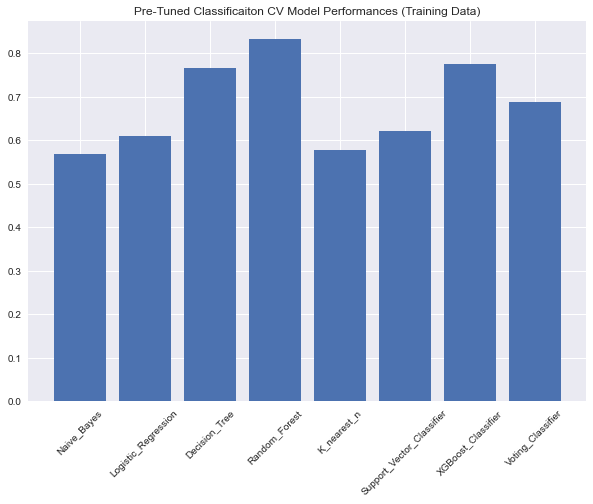

In [135]:
# show values in bar graph 
plt.figure(figsize=(10, 7))
keys = cv_results_dict.keys()
values = cv_results_dict.values()
plt.bar(keys, values)
plt.xticks(rotation='45')
plt.title("Pre-Tuned Classificaiton CV Model Performances (Training Data)");

## BRIEF RESULTS SUMMARY

* Definitively shows that the more complex models return significant accuracy improvements over the baseline naive bayes.
* The RF seems to perform quite well without additional tuning; the XGBoost underperforms but we can expect fairly significant accuracy gains for XGBoost and the SVC in tuning. 
* The simplier logistic_regression model doesn't outperform the baseline naive bayes by much, suggesting that investing in more sophisticated models will be worthwhile
    



<a id='tuned_models'></a>

# TUNED CLASSIFICATION MODEL PREDICTIONS 
* Tune the above models (Excluding Naive Bayes) and re-test the performance

In [136]:
# import additional packages for grid-searching to optimise some models 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# pickle models to avoid having to re-run lengthy optimisation processes [optional]
import pickle

In [137]:
## quick and easy print function for each model 
def model_performance_report(classifier, model_name):
    print('\n', "MODEL: ", model_name, '\n', '--'*15, '\n', )
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [139]:
# initialise model_tuned performance dictionary
cv_tuned_results_dict = {}

# TUNED LOGISTIC REGRESSION 

In [140]:
# initialise logistic_regression instance
lr = LogisticRegression()

# initialise param_grid of parameters to be optimised in the log-regression
## note: logspace = numbers spaced evenly on a log scale
param_grid = {'max_iter' : [2500],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}


# create the grid-search object CV, passing in the parameters to be optimsied from the param_grid
# note: n_jobs = -1 (will use all processors of your computer)
clf_lr = GridSearchCV(lr, param_grid=param_grid, 
                      cv = 5, 
                      verbose =True, 
                      n_jobs = -1)

# fit model passing in the grid-search object & our data: X_train and y_train
best_clf_lr = clf_lr.fit(X_train, y_train)

# pass in the auxiliary performance reporting function for the "best" / optimised parameter model chosen by grid-search
model_performance_report(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits

 MODEL:  Logistic Regression 
 ------------------------------ 

Best Score: 0.6354925775978407
Best Parameters: {'C': 4.281332398719396, 'max_iter': 2500, 'penalty': 'l2', 'solver': 'liblinear'}


In [141]:
## append results to dictionary 
cv_tuned_results_dict['tuned_logreg'] = np.round(best_clf_lr.best_score_,4)

## TUNED K-NEAREST NEIGHBORS

In [142]:
knn = KNeighborsClassifier()

# KNN PARAM GRID
param_grid = {'n_neighbors' : [3,5,7,9,11],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}

# run the KNN model with the grid_search passed in
clf_knn = GridSearchCV(knn, param_grid=param_grid, cv=5, 
                       verbose=True, n_jobs = -1)

# fit grid_searched model 
best_clf_knn = clf_knn.fit(X_train, y_train)

# print brief report
model_performance_report(best_clf_knn,'KNN')

Fitting 5 folds for each of 60 candidates, totalling 300 fits

 MODEL:  KNN 
 ------------------------------ 

Best Score: 0.7342780026990554
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}


In [143]:
## append results to dictionary 
cv_tuned_results_dict['tuned_knn'] = np.round(best_clf_knn.best_score_,4)

## TUNED SUPPORT VECTOR CLASSIFIER
* PARAM: C = default (1.0); strength of the regularisation parameter 

#### NARROW DOWN FEATURE SPACE WITH RANDOMIZED SEARCH 
* SVC can have massive storage requirements, which increase greatly with the number of features; even sparse matrix will utilise lots of memory and the solver used in the algorithm doesn't scale efficiently with large amounts of sample
* There are generally a few options if you are unable to perform the optimisation:
    * Potentially try using linearSVC, which is vastly more efficient in larger sample sizes
    * If data is sparse, replace (n) features with the average number of non-zero features in the sample vector
    * down-scale your original majority class to match the minority class (reducing the size of the data)
    * Tune the optimisation parameters (reduce max_iter) 

In [156]:
# fit the SVC with probability = True (internally uses 5-fold cross-validation)
svc = SVC(probability = True, cache_size=2000, max_iter=500)
# this max_iter is a hard_limit on iterations within solver
# default cache=200mb, which is too small to test many different iterations of models

# initialise param grid for randomized SVC params
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10]}]


# run CVC model with 20 parameter settings sampled
clf_svc_rnd = RandomizedSearchCV(svc, param_distributions=param_grid, 
                       cv= 5, verbose= True, n_jobs= -1, n_iter=40)

# fit the best model 
best_clf_svc_rnd = clf_svc_rnd.fit(X_train, y_train)

# print brief report
model_performance_report(best_clf_svc_rnd,'SVC_rndCV')

Fitting 5 folds for each of 40 candidates, totalling 200 fits

 MODEL:  SVC_rndCV 
 ------------------------------ 

Best Score: 0.9008097165991904
Best Parameters: {'kernel': 'rbf', 'gamma': 10, 'C': 1}


#### OPTIMIZE AROUND THE BEST PARAMETER FROM THE N_ITER(40) / CV=5,  RANDOMIZED SEARCH
* Although, it seems like the model isn't improved by further refinement anyhow

In [160]:
# fit the SVC with probability = True (internally uses 5-fold cross-validation)
svc = SVC(probability = True, cache_size=2000, max_iter=500)

# initialise param grid for SVC params
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [10, 15, 20],
                                  'C': [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.25, 2]}]

# run CVC model
clf_svc = GridSearchCV(svc, param_grid=param_grid, 
                       cv= 5, verbose= True, n_jobs= -1)

# fit the best model 
best_clf_svc = clf_svc.fit(X_train, y_train)

# print brief report
model_performance_report(best_clf_svc,'SVC')

Fitting 5 folds for each of 24 candidates, totalling 120 fits

 MODEL:  SVC 
 ------------------------------ 

Best Score: 0.9008097165991904
Best Parameters: {'C': 0.6, 'gamma': 10, 'kernel': 'rbf'}


In [161]:
## append results to dictionary 
cv_tuned_results_dict['tuned_svc'] = np.round(best_clf_svc.best_score_,4)

In [162]:
# save model [optional]
pickle.dump(best_clf_svc, open("svc_best.pickle.dat", "wb"))

## TUNED RANDOM FOREST CLASSIFIER
   
#### Because this data set has a very large total feature space which can be very computationally intensive 
* first, perform a randomized search of the params, then do a more refined search from those params

In [144]:
rf = RandomForestClassifier(random_state = 1)

# initialise param grid for random_forest
# note: default criterion is "gini" 
param_grid =  {'n_estimators': [100,500,1000], 
                                  'bootstrap': [True,False],
                                  'max_depth': [3,5,10,20,50,75,100,None],
                                  'max_features': ['auto','sqrt','log2'],
                                  'min_samples_leaf': [1,2,4,10],
                                  'min_samples_split': [2,5,10]}
    
## perform a randomized search of the params, then do a more refined search from those params
clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, 
                                n_iter = 100, cv = 5, verbose = True, n_jobs = -1)

# fit and print brief summary
best_clf_rf_rnd = clf_rf_rnd.fit(X_train, y_train)
model_performance_report(best_clf_rf_rnd,'Random Forest')

Fitting 5 folds for each of 100 candidates, totalling 500 fits

 MODEL:  Random Forest 
 ------------------------------ 

Best Score: 0.8439946018893387
Best Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}


## REFINED GRID-SEARCH FOR TUNED RANDOM FOREST CLASSIFIER 

In [145]:
rf = RandomForestClassifier(random_state = 1)

# pass in a range of values roughly around the Randomized Approximation values from above
param_grid =  {'n_estimators': [800,1000,1200],
               'criterion':['gini','entropy'],
                                  'bootstrap': [False],
                                  'max_depth': [None],
                                  'max_features': ['log2'],
                                  'min_samples_leaf': [1,2],
                                  'min_samples_split': [1,2,3]}
 
# fit the grid-search object
clf_rf = GridSearchCV(rf, param_grid = param_grid, 
                      cv = 5, verbose = True, n_jobs = -1)

best_clf_rf = clf_rf.fit(X_train, y_train)
model_performance_report(clf_rf,'Random Forest')

Fitting 5 folds for each of 36 candidates, totalling 180 fits

 MODEL:  Random Forest 
 ------------------------------ 

Best Score: 0.8492577597840756
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1000}


In [146]:
cv_tuned_results_dict['tuned_rfc'] = np.round(best_clf_rf.best_score_,4)

In [147]:
# save model 
pickle.dump(best_clf_rf, open("rf_best.pickle.dat", "wb"))

# load model 
#best_clf_rf = pickle.load(open("rf_best.pickle.dat", "rb"))

### SHOW FEATURE IMPORTANCES IN RF
* visualise the contribution of the 30 largest features in the RF classification algoirithm.

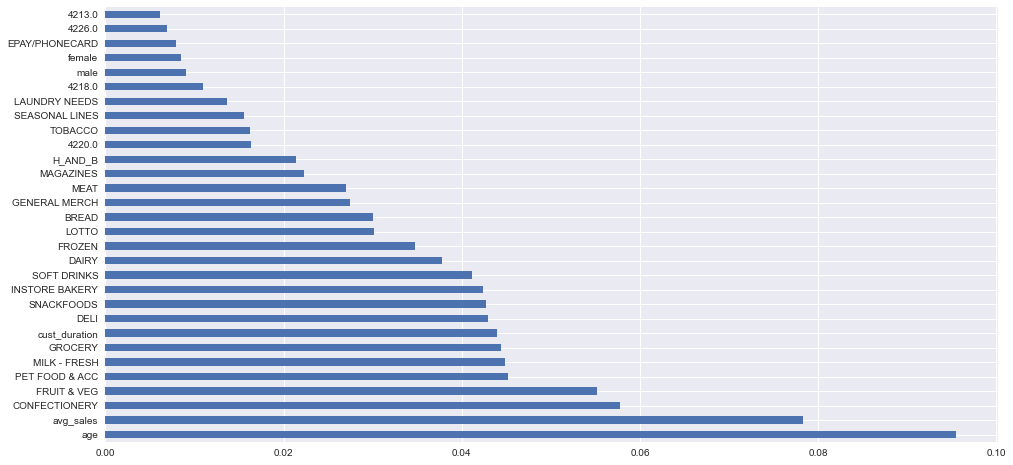

In [149]:
best_rf = best_clf_rf.best_estimator_.fit(X_train,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
plt.figure(figsize=(16,8))
feat_importances.nlargest(30).plot(kind='barh');

### BRIEF TAKEAWAYS ON RF CLASSIFIER & DEPARTMENT CONTRIBUTIONS  [FIX REQUIRED]

* Fairly expected insights:
    * Age plays an important role in informing the email-opt in decision; this is likely related to the uptake of new technologies among different age groups. 
    * (Fruit & Veg) and (Confectionery) are heavily marketed items online and in the catalogue, and is expected to be an important "draw card" for customer shopping / customer behaviour influence
    * While Tobacco was a massive contributor to overall sales earlier, as expected it doesn't play a significant role in loyalty customer behaviour; likely stemming from the fact that tobacco sales do not provide loyalty points
    * Customer duration is important, the longer you frequent the same location, the more likely you are to subscribe to the email specials for that location - fairly logical to presume but useful to see it statistically represented here.
    * Sales are important, customers who spend more are more likely to opt into the email marketing; conversely, the causality could in a continuous cycle, as customer's who opt into the marketing also then subsequently spend more. Either way, this isn't exactly a novel discovery 
   
   
* somewhat surprising takeaways: 
    * Slightly surprising to see the "top-up" shop items: (milk, pet food, snackfoods, softdrinks) among some of the most important features as email opt-in shoppers are expected to partake in more 'staple' purchases like (meat, deli)
    * post code (proximity to store) is not as important as expected, the most geographically close post_code only represents about the (20th) top feature. 
    * Gender is not important in the email-marketing decision
        * Although, this was slightly supported by the non-significant difference seen in the two groups means in the initial data exploration section

## TUNED XGBOOST 

### FIRST NARROW DOWN FEATURE SPACE WITH RANDOMIZED SEARCH
* NOTE: even the randomized search of over the param_grid options can take a long time to run, even with a fast PC. If the code is unable to finish running, try reducing the cross_validations (CV=5) or n_iter (I lowered 1000 > 250, try even 100)

In [150]:
xgb = XGBClassifier(random_state=1)

# different param featrues to be randomly iterated over 
param_grid = {
    'n_estimators': [20, 50, 100, 250, 500, 1000],
    'colsample_bytree': [0.2, 0.5, 0.7, 0.8, 1],
    'max_depth': [2, 5, 10, 15, 20, 25, None],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'learning_rate':[.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9],
    'gamma':[0, .01, 0.1, 1, 10, 100],
    'min_child_weight':[0, .01, 0.1, 1, 10, 100],
    'sampling_method': ['uniform', 'gradient_based']}

# run the randomized search on param grid
clf_xgb_rnd = RandomizedSearchCV(xgb, param_distributions = param_grid, n_iter = 250, 
                                 cv = 5, verbose = True, n_jobs = -1)

# fit the best randomizedsearch_CV model and print brief summary
best_clf_xgb_rnd = clf_xgb_rnd.fit(X_train, y_train)
model_performance_report(best_clf_xgb_rnd,'XGB')

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[12:46:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 MODEL:  XGB 
 ------------------------------ 

Best Score: 0.8387314439946018
Best Parameters: {'subsample': 0.8, 'sampling_method': 'uniform', 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 1000, 'min_child_weight': 0.1, 'max_depth': 15, 'learning_rate': 0.7, 'gamma': 0, 'colsample_bytree': 1}


## FIT A MORE REFINED XGBOOST MODEL WITH THE PREVIOUSLY OPTIMAL PARAMETERS FROM RANDOMIZED SEARCH

In [151]:
xgb = XGBClassifier(random_state=1)

# refine each parameter in a small range around the above randomized-param values
param_grid = {
    'n_estimators': [800, 1000, 1200],
    'colsample_bytree': [1, 1.2],
    'max_depth': [13, 15, 17],
    'reg_alpha': [0],
    'reg_lambda': [1.2, 1.5, 1.7],
    'subsample': [0.8],
    'learning_rate':[0.7, 0.8],
    'gamma':[0, 0.01],
    'min_child_weight':[0.1, 0.3, 0.5],
    'sampling_method': ['uniform']}

# fit the model from the now refined-grid params
clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)

# fit best model and print brief summary
best_clf_xgb = clf_xgb.fit(X_train, y_train)
model_performance_report(best_clf_xgb,'XGB')

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[12:54:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 MODEL:  XGB 
 ------------------------------ 

Best Score: 0.8441295546558705
Best Parameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.7, 'max_depth': 13, 'min_child_weight': 0.1, 'n_estimators': 800, 'reg_alpha': 0, 'reg_lambda': 1.2, 'sampling_method': 'uniform', 'subsample': 0.8}


In [152]:
cv_tuned_results_dict['tuned_xgb'] = np.round(best_clf_xgb.best_score_,4)

In [153]:
# save model 
pickle.dump(best_clf_xgb, open("xgboost_best.pickle.dat", "wb"))

## TUNED CLASSIFICATION MODEL RESULTS 
* Model scores on the training data set

In [194]:
cv_tuned_results_dict

{'tuned_logreg': 0.6355,
 'tuned_knn': 0.7343,
 'tuned_rfc': 0.8493,
 'tuned_xgb': 0.8441,
 'tuned_svc': 0.9008}

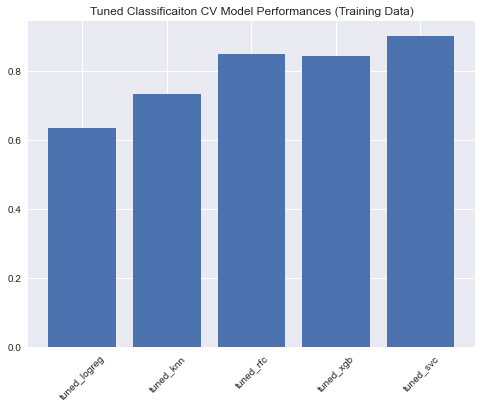

In [197]:
# show values in bar graph 
plt.figure(figsize=(8, 6))
keys = cv_tuned_results_dict.keys()
values = cv_tuned_results_dict.values()
plt.bar(keys, values)
plt.xticks(rotation='45')
plt.title("Tuned Classificaiton CV Model Performances (Training Data)");

### BRIEF TAKEAWAYS: 
* Tuned logistic regression has a mild gain ~ 3%, not enough to be considered.
* While tuned KNN sees a very generous increase: 58% to 73%, it still underperforms
* RF classifier imrpoved only marginally, a little over 1% but its un-tuned performance means the model might have application in larger data sets with less computing power / resources to optimize the other models
* XGB sees a modest gain of around 7%, but the computational burden is significantly higher than the RFC, and loses out in that respect
* tuned SVC sees a massive gain 62% to 90%, a clear winner
    * Although, the SVC may have problems adapting to larger data sets, more so than any other model, which affects its viability on a massive scale without further internal optimisations

<a id='add_vc'></a>

## ADDITIONAL MODEL APPROACHES: VOTING CLASSIFIER MODIFICATIONS 
* useful tool if we are not 100% sure which classifier is right for the problem

### EXPLANATION
* Hard = popular vote, majority wins
* Soft = predicts the winner based on the argmax of the sums of the predicted probabilities 
    * Soft is considered superior if the classification models have been prior calibrated

In [188]:
# import a package to more easily visualise the results in table format
from tabulate import tabulate

In [182]:
# define our best estimators from each model for clarity 
best_lr = best_clf_lr.best_estimator_     # best logistic regression 
best_knn = best_clf_knn.best_estimator_   # best k-nearest neighbors
best_svc = best_clf_svc.best_estimator_   # best support vector classifier  
best_rf = best_clf_rf.best_estimator_     # best random forest 
best_xgb = best_clf_xgb.best_estimator_   # best XGBoost

* define the different iterations of voting classifiers
    * soft vs hard
    * sub-sample of models vs all models

In [183]:
voting_clf_soft = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], 
                                   voting = 'soft') 

In [184]:
voting_clf_hard = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], 
                                   voting = 'hard') 

In [185]:
voting_clf_all = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('lr', best_lr)], 
                                  voting = 'soft') 

In [186]:
voting_clf_xgb = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('xgb', best_xgb),
                                                ('lr', best_lr)], 
                                  voting = 'soft')

In [190]:
print(tabulate([['VOTING CLF SOFT:', cross_val_score(voting_clf_soft,X_train,y_train,cv=5).mean()],
              ['VOTING CLF HARD:', cross_val_score(voting_clf_hard,X_train,y_train,cv=5).mean()],
                ['VOTING CLF ALL: ', cross_val_score(voting_clf_all,X_train,y_train,cv=5).mean()], 
                ['VOTING CLF XBG: ',cross_val_score(voting_clf_xgb,X_train,y_train,cv=5).mean()]],
               headers=['VOTING CLASSIFIER','MODEL 5-CV MEAN'],
                tablefmt='pretty', numalign='center'))

[13:08:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:08:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:08:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:08:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

* Conversely, the hard classifier outperforms the soft classifier with the same 3 models
    * this might be addressed by influencing the weights of each model within the voter

### EXPERIMENT WIHT USING DIFFERENT MODEL WEIGHTS IN THE SOFT VOTING CLASSIFIER 
* A grid search will iterate through different weightings 

#### TRY EXPERIMENT WITH DIFFERENT WEIGHTS ON THE TWO BEST SOFT VOTING CLASSIFIERS

In [192]:
# initialise dictionary of param weights 
params_soft_vc = {'weights' : [[1,1,1],[1,1,2],[1,2,1],[1,2,2],
                       [2,1,1],[2,2,1],[2,1,2]]}


In [193]:
# pass in the weights dict as the param grid 
vote_weights = GridSearchCV(voting_clf_soft, param_grid=params_soft_vc, 
                           cv = 5, verbose = True, n_jobs = -1)

# fit the best model
best_clf_weight = vote_weights.fit(X_train, y_train)

# print results
model_performance_report(best_clf_weight,'VC-soft Weights')

Fitting 5 folds for each of 7 candidates, totalling 35 fits

 MODEL:  VC-soft Weights 
 ------------------------------ 

Best Score: 0.8748987854251012
Best Parameters: {'weights': [1, 1, 2]}


* adjusting the weights to further weight the SVC results in a higher score (unsurprising, as the SVC alone has a higher score than the voting classifier) 

## Experiment with different weightings for the 5 models
* Try iterations with more weight on the models we know performed best on the single model cross-validation steps

In [198]:
params_soft_xgb = {'weights' : [[1,1,1,1,1],[1,1,2,1,1],[1,1,2,2,1],[1,2,2,2,1]]}

In [199]:
# pass in the weights dict as the param grid 
vote_weights = GridSearchCV(voting_clf_xgb, param_grid=params_soft_xgb, 
                           cv = 5, verbose = True, n_jobs = -1)

# fit the best model
best_clf_weight = vote_weights.fit(X_train, y_train)

# print results
model_performance_report(best_clf_weight,'VC-soft Weights: XGB')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[13:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 MODEL:  VC-soft Weights: XGB 
 ------------------------------ 

Best Score: 0.8855600539811066
Best Parameters: {'weights': [1, 1, 2, 2, 1]}


* Not entirely surprising that the model with extra weight on the: SVC and XGBoost performed better, given these models outperformed individually as well.

### BRIEF TAKEAWAYS ON THE VOTING CLASSIFIER
* Somewhat unsurprisingly, the models with extra weight on the already outperforming models perform better. 
* Given the additional complexities of forecasting the test data set with a voting classifier and the fact it is not essentially providing any additional "value" by over-weighting the model we already know performs best, we will perform test-data predictions with the individual tuned models only

<a id='oos_models'></a>

## OUT OF SAMPLE (TEST-DF) PREDICTIONS FROM TUNED MODELS
* Use the tuned model from the training data to predict outcomes from the test data for each of the tuned models

In [200]:
# initialise a dictionary for these test data results
tuned_model_test_results = {}

In [167]:
# define our best estimators from each model: 
best_lr = best_clf_lr.best_estimator_     # best logistic regression 
best_knn = best_clf_knn.best_estimator_   # best k-nearest neighbors
best_svc = best_clf_svc.best_estimator_   # best support vector classifier  
best_rf = best_clf_rf.best_estimator_     # best random forest 
best_xgb = best_clf_xgb.best_estimator_   # best XGBoost

In [168]:
# test model on data inputs of x_test to get results of y_test
log_reg_pred = best_lr.predict(X_test).astype(int)
knn_pred = best_knn.predict(X_test).astype(int)
svc_pred = best_svc.predict(X_test).astype(int) 
rf_pred = best_rf.predict(X_test).astype(int) 
xbg_pred = best_xgb.predict(X_test).astype(int) 

In [203]:
# append the test-df model accuracy results (using: roc_auc score)
tuned_model_test_results['tuned_lr'] = np.round(roc_auc_score(y_test, log_reg_pred),4)
tuned_model_test_results['tuned_knn'] = np.round(roc_auc_score(y_test, knn_pred),4)
tuned_model_test_results['tuned_svc'] = np.round(roc_auc_score(y_test, svc_pred),4)
tuned_model_test_results['tuned_rf'] = np.round(roc_auc_score(y_test, rf_pred),4)
tuned_model_test_results['tuned_xgb'] = np.round(roc_auc_score(y_test, xbg_pred),4)

<a id='model_results'></a>

## MODEL RESULTS SUMMARY AND DISCUSSION

* Interestingly enough, (Ex. logistic regression) each of the models performed better on the test data than on the training data. 
* The RFC gained almost 10% accuracy and the SVC around 5%, this might suggests that the models were not overly fitted to the training data and actually have predictive capacity in correctly classifying new data
    * One avenue to explore is whether the upscaling of the minority class has contributed to this in any way, thus, the total data set should be recalibrated in the future and different techniques of class balancing should be tried to ensure the results continue to hold true.

In [204]:
# show results 
tuned_model_test_results

{'tuned_lr': 0.625,
 'tuned_knn': 0.75,
 'tuned_svc': 0.9583,
 'tuned_rf': 0.9583,
 'tuned_xgb': 0.875}

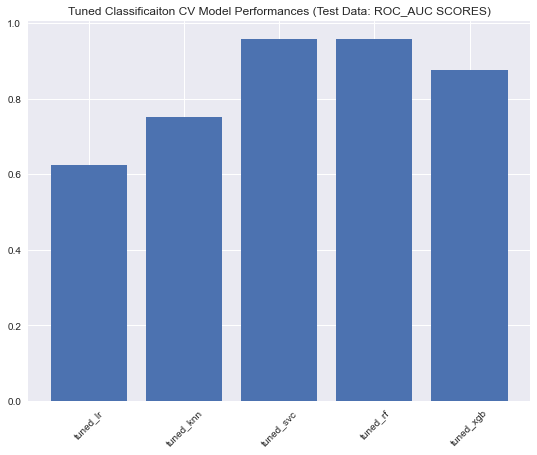

In [207]:
# show values in bar graph 
plt.figure(figsize=(9, 7))
keys = tuned_model_test_results.keys()
values = tuned_model_test_results.values()
plt.bar(keys, values)
plt.xticks(rotation='45')
plt.title("Tuned Classificaiton CV Model Performances (Test Data: ROC_AUC SCORES)");